In [57]:
import numpy as np
import matplotlib.pyplot as plt

class image_unit:
    def __init__(self) -> None:
        self.num_of_points = 0
        self.cord_of_points = np.array([])
        self.raw_image = np.array([])
    def print_data(self) -> None:
        print(self.num_of_points)
        print(self.cord_of_points)
        print(self.raw_image)
        # Plotting the array as a grayscale image
        plt.imshow(self.raw_image, cmap='viridis')
        plt.colorbar()  # Adding a colorbar to show intensity scale
        plt.title('Visualization')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.show()

100
No. 1
<class 'numpy.float64'>
10
[[ 4.90713266 28.03953829]
 [32.84440351 13.57851211]
 [52.97361097 13.17095481]
 [ 6.08836544  8.06791729]
 [16.43699632 10.29119369]
 [51.67877819 59.35360808]
 [30.56994402 52.70290573]
 [20.15551056 48.03884791]
 [41.31064392  7.4202662 ]
 [22.6720807  19.91307516]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


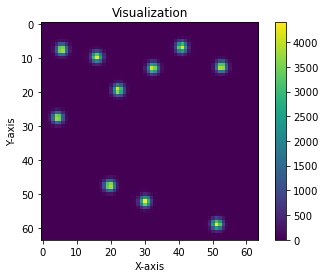

In [58]:
# Specify the path to your text file
file_path = './Clusters_2D_100.txt'
images = []

# For every image:
# Line 1: number of points(10)
# Line 2-11: exact positions of the points
# Others: grayscale image
with open(file_path, 'r') as file:
    cop = [] # Store cordinates of points tempoarily
    ri = [] # Store raw image tempoarily
    for line in file:
        numbers = []
        numbers = [float(s) for s in line.strip().split()]
        if len(numbers) == 1:
            if len(images) > 0:
                images[-1].raw_image = np.array(ri).T
                ri.clear()
            images.append(image_unit())
            images[-1].num_of_points = int(numbers[0])
        elif len(numbers) == 2:
            cop.append(numbers)
            if len(cop) == images[-1].num_of_points:
                images[-1].cord_of_points = np.array(cop)
                cop.clear()
        else:
            ri.append(numbers)
    images[-1].raw_image = np.array(ri).T

print(len(images))

# Print the list of numbers
for i in range(1):
    print('No.', i + 1)
    print(type(images[i].raw_image[0][0]))
    images[i].print_data()

In [59]:
def find_local_maxima(matrix):
    rows = len(matrix)
    cols = len(matrix[0])
    
    def is_local_maxima(i, j):
        current = matrix[i][j]
        # Check all eight possible neighbors
        neighbors = [
            (i-1, j-1), (i-1, j), (i-1, j+1),
            (i, j-1),            (i, j+1),
            (i+1, j-1), (i+1, j), (i+1, j+1)
        ]
        for x, y in neighbors:
            if 0 <= x < rows and 0 <= y < cols:
                if matrix[x][y] >= current:
                    return False
        return True

    local_maxima = []
    for i in range(rows):
        for j in range(cols):
            if is_local_maxima(i, j):
                local_maxima.append((j, i))
    
    return local_maxima

# 查找局部最大值 Find the local maximum
local_maxima = find_local_maxima(images[0].raw_image)


print("Local Maxima:", local_maxima) # 局部最大值的位置

Local Maxima: [(41, 7), (6, 8), (16, 10), (32, 13), (52, 13), (22, 19), (4, 28), (20, 48), (30, 52), (51, 59)]


In [60]:
import cv2

# Define the color (B, G, R) and thickness of the cross marks
# color = (0, 255, 0)  # Green color
# cross_length = 10  # Length of the cross arms
# thickness = 2  # Thickness of the lines
def mark_point(image: np.array, points: list, color = (0, 255, 0), type = 'normal', cross_length = 2, thickness = 1) -> np.array:
    # Ensure the image is a NumPy array with the correct dtype
    if image.dtype != np.uint8:
        marked_image = (image / np.max(image) * 255).astype(np.uint8)
    else:
        marked_image = np.copy(image)
    if len(marked_image.shape) == 2 or (len(marked_image.shape) == 3 and marked_image.shape[2] == 1):
        marked_image = cv2.applyColorMap(marked_image, cv2.COLORMAP_TWILIGHT_SHIFTED)
    if type == 'normal':
        for (x, y) in points:
            cv2.line(marked_image, (x - cross_length, y), (x + cross_length, y), color, thickness)
            cv2.line(marked_image, (x, y - cross_length), (x, y + cross_length), color, thickness)
    elif type == 'skew':
        for (x, y) in points:
            cv2.line(marked_image, (x - cross_length, y - cross_length), (x + cross_length, y + cross_length), color, thickness)
            cv2.line(marked_image, (x + cross_length, y - cross_length), (x - cross_length, y + cross_length), color, thickness)
    # Display the image with marked points
    return marked_image

[(4.90713265801572, 28.039538291703874), (32.84440350822294, 13.578512105334035), (52.973610967129076, 13.170954812016848), (6.088365442640924, 8.067917290512826), (16.436996322861567, 10.291193687624183), (51.67877819316273, 59.35360808253424), (30.56994401674475, 52.702905728831574), (20.15551056223808, 48.038847909050986), (41.31064392120531, 7.420266202730436), (22.67208069830488, 19.913075159064046)]


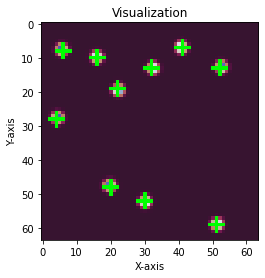

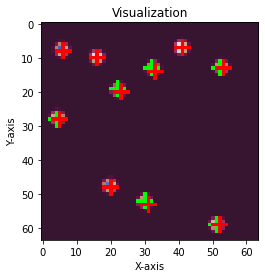

In [61]:
print([tuple(row) for row in images[0].cord_of_points])
marked_test = mark_point(images[0].raw_image, find_local_maxima(images[0].raw_image))
plt.imshow(marked_test)
plt.title('Visualization')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()
marked_test = mark_point(marked_test, [tuple(row) for row in np.round(images[0].cord_of_points).astype(int)], (255, 0, 0))
plt.imshow(marked_test)
plt.title('Visualization')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

[[-0.3106439212053118, -0.4202662027304358, 0.5226120233397542], [-0.08836544264092439, -0.0679172905128258, 0.11145048139748018], [-0.4369963228615674, -0.2911936876241832, 0.525128127133466], [-0.8444035082229391, -0.5785121053340347, 1.0235690209835508], [-0.9736109671290762, -0.17095481201684848, 0.9885058740673882], [-0.6720806983048817, -0.9130751590640465, 1.133754255177819], [-0.90713265801572, -0.039538291703873796, 0.9079939073306196], [-0.15551056223808146, -0.03884790905098612, 0.1602894101468899], [-0.5699440167447491, -0.7029057288315741, 0.9049379237535496], [-0.6787781931627279, -0.3536080825342367, 0.7653616867513013], [-0.6800221327946225, -0.715902695487145, 0.9873939287317434], [-0.9353136686999477, -0.9411536260419258, 1.3268691746622274], [-0.8226695302642071, -0.6208423553782332, 1.0306456162312647], [-0.33884528651555, -0.9376472237681348, 0.9969947063219021], [-0.7113829072370947, -0.7880457029255865, 1.0616410271879015], [-0.48366985399977835, -0.6024487530084

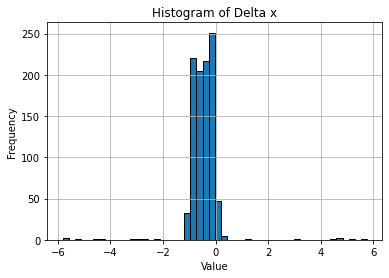

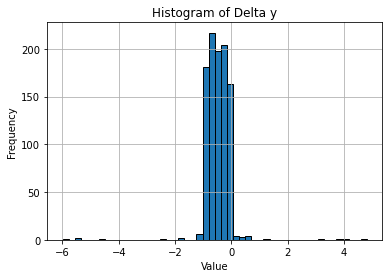

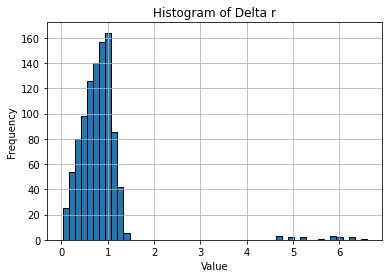

In [63]:
import math
def distance(p, q):
    # Function to calculate Euclidean distance between points p and q
    return math.sqrt((q[0] - p[0])**2 + (q[1] - p[1])**2)

def smallest_distance_to_set(point, point_set):
    # point is a tuple (x, y) representing the point P
    # point_set is a list of tuples [(x1, y1), (x2, y2), ...] representing the set S
    
    if not point_set:
        return float('inf')  # If point_set is empty, return infinity
    
    x_distance = float('inf')
    y_distance = float('inf')
    min_distance = float('inf')
    
    for q in point_set:
        dist = distance(point, q)
        if dist < min_distance:
            min_distance = dist
            x_distance = point[0] - q[0]
            y_distance = point[1] - q[1]
    
    return [x_distance, y_distance, min_distance]

dist = []
large_error = []
for i in range (len(images)):
    finded = find_local_maxima(images[i].raw_image)
    for j in range(len(finded)):
        dist.append(smallest_distance_to_set(finded[j], [tuple(row) for row in images[i].cord_of_points]))
        if dist[-1][2] > 2.0 and (len(large_error) == 0 or large_error[-1] != i):
            large_error.append(i)

print(dist)
dist_array = np.array(dist).T   
print(dist_array.shape)
print(dist_array)
print(large_error)

# Plotting the histogram
plt.hist(dist_array[0], bins=50, edgecolor='black')  # Adjust bins as needed
plt.title('Histogram of Delta x')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.hist(dist_array[1], bins=50, edgecolor='black')  # Adjust bins as needed
plt.title('Histogram of Delta y')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.hist(dist_array[2], bins=50, edgecolor='black')  # Adjust bins as needed
plt.title('Histogram of Delta r')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

[7, 18, 20, 21, 33, 53, 56, 61, 74, 78, 81, 84, 86, 91, 94]


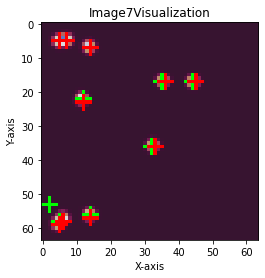

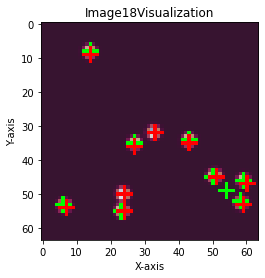

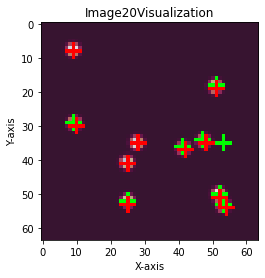

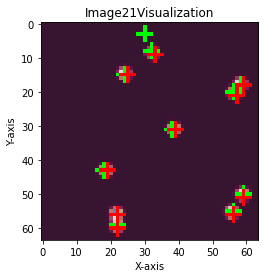

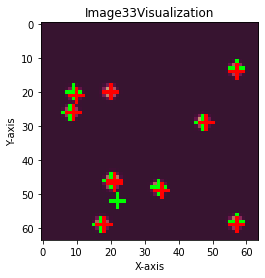

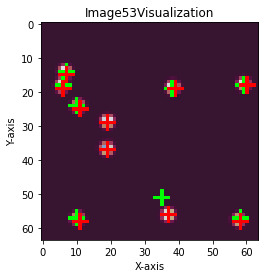

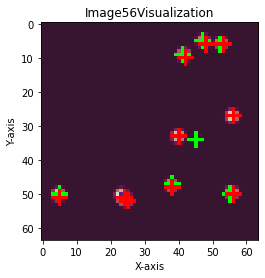

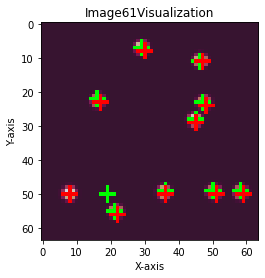

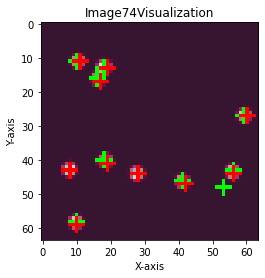

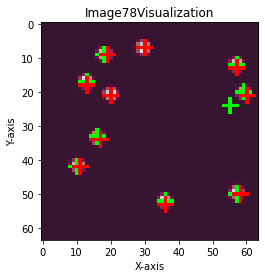

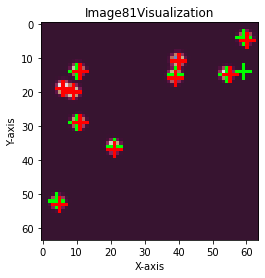

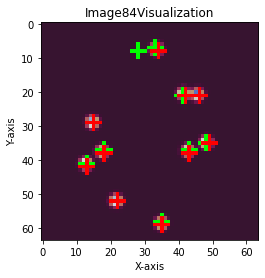

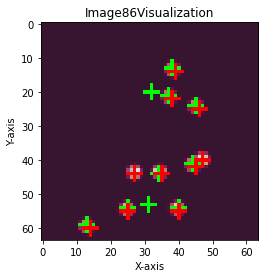

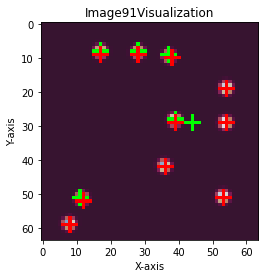

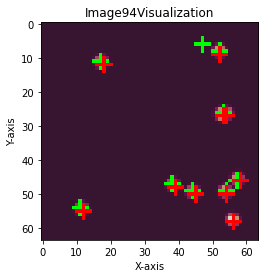

In [65]:
print(large_error)
for i in large_error:
    marked_test = mark_point(images[i].raw_image, find_local_maxima(images[i].raw_image))
    marked_test = mark_point(marked_test, [tuple(row) for row in np.round(images[i].cord_of_points).astype(int)], (255, 0, 0))
    plt.imshow(marked_test)
    plt.title('Image ' + str(i) + ' Visualization')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()